In [ ]:
!pip install -q -U datasets accelerate peft
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q huggingface-hub==1.3.1
!pip install -U bitsandbytes>=0.46.1
!pip install -q jiwer
!pip install Pillow==11.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 42.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.4/533.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 33.9 MB/s eta 0:00:00


## Load Dataset

For this example, we'll use the **IAM handwriting dataset** from [HuggingFaceM4/FineVision](https://huggingface.co/datasets/HuggingFaceM4/FineVision) to finetune the model on handwritten text recognition ✍️.

**FineVision Dataset Structure:**
- `images`: List of PIL Images
- `texts`: List of conversation dicts with:
  - `user`: Question/prompt(we ignore this one)
  - `assistant`: OCR ground truth text
- `source`: Dataset source identifier

**Other available subsets:**
- `olmOCR-mix-0225-books` - Books subset of olmOCR-mix-0225 📚
- `olmOCR-mix-0225-documents` - Document subset olmOCR-mix-0225 📄
- And many more! See the [FineVision dataset page](https://huggingface.co/datasets/HuggingFaceM4/FineVision) for all available datasets.

In [ ]:
import torch
from datasets import load_dataset

# choose dataset subset
# finevision_subset = "iam"
# finevision_subset = "olmOCR-mix-0225-books"
# finevision_subset = "olmOCR-mix-0225-documents"
# lightonai/LightOnOCR-bbox-mix-0126
finevision_subset ="invoices_receipts"
train_ds = load_dataset(
    "HuggingFaceM4/FineVision", finevision_subset, split="train[:85%]"
)
val_ds = load_dataset(
    "HuggingFaceM4/FineVision", finevision_subset, split="train[85%:95%]"
)
test_ds = load_dataset(
    "HuggingFaceM4/FineVision", finevision_subset, split="train[95%:]"
)

print(
    f"Training samples: {len(train_ds)}, Validation samples: {len(val_ds)}, Test samples: {len(test_ds)}"
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

invoices_receipts/train-00000-of-00004.p(…):   0%|          | 0.00/477M [00:00<?, ?B/s]

invoices_receipts/train-00001-of-00004.p(…):   0%|          | 0.00/500M [00:00<?, ?B/s]

invoices_receipts/train-00002-of-00004.p(…):   0%|          | 0.00/482M [00:00<?, ?B/s]

invoices_receipts/train-00003-of-00004.p(…):   0%|          | 0.00/464M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3013 [00:00<?, ? examples/s]

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Training samples: 2561, Validation samples: 301, Test samples: 151


## Load Model and Processor

We'll load the LightOnOCR model with full fine-tuning (optionally freezing parts of the model to reduce memory requirements).

### Available Checkpoints 🆕

You can finetune any of the LightOnOCR-2 model checkpoints:

- **`LightOnOCR-2-1B`** — Default; OCR-only, best transcription
- **`LightOnOCR-2-1B-bbox`** — BBOX-focused; OCR + embedded image localization
- **`LightOnOCR-2-1B-ocr-soup`** — Tradeoff checkpoint combining OCR + BBOX strengths
- **`LightOnOCR-2-1B-base`** — Base checkpoint, OCR-only; for fine-tuning / merging
- **`LightOnOCR-2-1B-bbox-base`** — Base checkpoint with BBOX capability; ideal for RLVR training
- **`LightOnOCR-2-1B-bbox-soup`** — Merged BBOX variant; balances OCR quality and image localization

In [ ]:
import torch
from transformers import LightOnOcrProcessor


# model_id = "lightonai/LightOnOCR-1B-1025"
model_id = "lightonai/LightOnOCR-2-1B" # or any of the above checkpoints

device = "cuda:0" if torch.cuda.is_available() else "cpu"

processor = LightOnOcrProcessor.from_pretrained(model_id)
processor.tokenizer.padding_side = "left"

print(f"Using device: {device}")

processor_config.json: 0.00B [00:00, ?B/s]

chat_template.jinja:   0%|          | 0.00/720 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

Using device: cpu




> Note: this cell fails sometimes! but it's enough to restart the notebook and it works!



In [ ]:
from transformers import LightOnOcrForConditionalGeneration

model = LightOnOcrForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa",
    device_map="cuda:0" if torch.cuda.is_available() else "cpu",
).to(device)

# # freeze vision encoder, projector or language model to reduce memory requirements on Colab
# for param in model.model.vision_encoder.parameters():
#     param.requires_grad = False
# print(f"Vision encoder frozen: {param.requires_grad}")
# for param in model.model.vision_projection.parameters():
#     param.requires_grad = False
# print(f"Vision projection frozen: {param.requires_grad}")
for param in model.model.language_model.parameters():
    param.requires_grad = False
print(f"Language model frozen: {param.requires_grad}")

You are using a model of type mistral3 to instantiate a model of type lighton_ocr. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/2.01G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/532 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/219 [00:00<?, ?B/s]

Language model frozen: False


### Option 2: LoRA Fine-tuning

Uncomment this cell to use LoRA instead of full fine-tuning. This is more memory efficient and recommended for limited GPU resources.

In [ ]:
# from transformers import LightOnOCRForConditionalGeneration, BitsAndBytesConfig
# from peft import get_peft_model, LoraConfig, prepare_model_for_kbit_training
# import torch

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_compute_dtype=torch.bfloat16,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4"
# )

# model = LightOnOCRForConditionalGeneration.from_pretrained(
#     model_id,
#     device_map="auto",
#     torch_dtype=torch.bfloat16,
#     quantization_config=bnb_config
# )

# model = prepare_model_for_kbit_training(model)

# # # convert vision encoder to bfloat16 to match input dtype
# # if hasattr(model, 'model') and hasattr(model.model, 'vision_encoder'):
# #     model.model.vision_encoder = model.model.vision_encoder.to(torch.bfloat16)

# lora_config = LoraConfig(
#     r=8,
#     lora_alpha=16,
#     target_modules=["o_proj", "gate_proj", "up_proj", "down_proj"],
#     lora_dropout=0.05,
#     bias="none",
#     task_type="CAUSAL_LM"
# )

# model = get_peft_model(model, lora_config)
# model.print_trainable_parameters()

# print("Model loaded with 4-bit quantization + LoRA")

## Prepare Data Collator

The data collator prepares batches for training. It:
1. Formats prompts with image tokens using chat template
2. Processes images and text through the processor
3. Creates labels for training (masking prompt tokens, only training on assistant response)

In [ ]:
# assistant start pattern: <|im_end|>\n<|im_start|>assistant\n
ASSISTANT_START_PATTERN = [151645, 198, 151644, 77091, 198]
MAX_LENGTH = 1024
LONGEST_EDGE = 700


def collate_fn(examples):
    batch_messages = []
    batch_images = []

    for example in examples:
        example_images = example["images"]
        example_texts = example["texts"]

        assert len(example_images) == 1, (
            f"Expected 1 image per sample, got {len(example_images)}"
        )
        assert len(example_texts) == 1, (
            f"Expected 1 text per sample, got {len(example_texts)}"
        )

        image = example_images[0].convert("RGB")
        batch_images.append(image)

        conversation = example_texts[0]
        # strip extra whitespaces and newlines to avoid tokenization issues
        assistant_text = conversation.get("assistant", "").strip()

        messages = [
            {"role": "user", "content": [{"type": "image"}]},
            {
                "role": "assistant",
                "content": [{"type": "text", "text": assistant_text}],
            },
        ]
        batch_messages.append(messages)

    if len(batch_images) == 0:
        return None

    texts = [
        processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=False
        )
        for messages in batch_messages
    ]

    inputs = processor(
        text=texts,
        images=batch_images,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
        size={"longest_edge": LONGEST_EDGE},  # reduce due to memory requirements
    )

    labels = inputs["input_ids"].clone()
    pad_token_id = processor.tokenizer.pad_token_id

    for i in range(len(labels)):
        full_ids = inputs["input_ids"][i].tolist()

        # find where assistant content starts (after the assistant marker)
        assistant_content_start = None
        for idx in range(len(full_ids) - len(ASSISTANT_START_PATTERN)):
            if (
                full_ids[idx : idx + len(ASSISTANT_START_PATTERN)]
                == ASSISTANT_START_PATTERN
            ):
                assistant_content_start = idx + len(ASSISTANT_START_PATTERN)
                break

        if assistant_content_start is None:
            print(f"Warning: Could not find assistant marker in sample {i}")
            print(f"Sample {i} failed. Text: {texts[i]}")
            labels[i, :] = -100
        else:
            # mask everything first
            labels[i, :] = -100

            # unmask from assistant content start to end
            # this trains on: assistant text + EOS
            for idx in range(assistant_content_start, len(full_ids)):
                if full_ids[idx] == pad_token_id:
                    break
                labels[i, idx] = inputs["input_ids"][i, idx]

        # mask padding tokens
        labels[i, inputs["input_ids"][i] == pad_token_id] = -100

    inputs["labels"] = labels

    # convert tensors to device with proper dtype
    inputs["pixel_values"] = inputs["pixel_values"].to(torch.bfloat16)

    return inputs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

image_dir = "/content/drive/MyDrive/r2/image"
html_dir = "/content/drive/MyDrive/r2/html_files"

# lấy tên file KHÔNG có đuôi
image_names = {
    os.path.splitext(f)[0]
    for f in os.listdir(image_dir)
    if f.lower().endswith(".png")
}

html_names = {
    os.path.splitext(f)[0]
    for f in os.listdir(html_dir)
    if f.lower().endswith(".html")
}

# ảnh không có html tương ứng
missing_html = sorted(image_names - html_names)

# html không có ảnh tương ứng
missing_image = sorted(html_names - image_names)

print(f"Total images: {len(image_names)}")
print(f"Total htmls : {len(html_names)}")

# print("\n❌ Images KHÔNG có file HTML tương ứng:")
# for name in missing_html:
#     print(name + ".png")

# print("\n❌ HTML KHÔNG có file ảnh tương ứng:")
# for name in missing_image:
#     print(name + ".html")


Total images: 35636
Total htmls : 42813


In [ ]:
import os
import time
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service

HTML_DIR = "/content/drive/MyDrive/r2/html_files"
OUT_DIR  = "/content/drive/MyDrive/r2/images"

os.makedirs(OUT_DIR, exist_ok=True)

chrome_options = Options()
chrome_options.binary_location = "/usr/bin/chromium-browser"   # QUAN TRỌNG
chrome_options.add_argument("--headless=new")          # QUAN TRỌNG
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--window-size=1280,2000")

service = Service("/usr/bin/chromedriver")

driver = webdriver.Chrome(
    service=service,
    options=chrome_options
)

for file in sorted(os.listdir(HTML_DIR)):
    if not file.endswith(".html"):
        continue

    html_path = os.path.join(HTML_DIR, file)
    out_path = os.path.join(
        OUT_DIR,
        file.replace(".html", ".png")
    )

    driver.get("file://" + html_path)
    time.sleep(0.5)

    width = driver.execute_script("return document.body.scrollWidth")
    height = driver.execute_script("return document.body.scrollHeight")
    driver.set_window_size(width, height)

    time.sleep(0.2)
    driver.save_screenshot(out_path)

    print(f"✅ Saved: {out_path}")

driver.quit()


WebDriverException: Message: Service /usr/bin/chromedriver unexpectedly exited. Status code was: 1


In [ ]:
!which chromium-browser
!which chromedriver


/usr/bin/chromium-browser
/usr/bin/chromedriver


In [ ]:
!apt-get update
!apt-get install -y chromium-browser chromium-chromedriver
!pip install -U selenium pillow


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://cli.github.com/packages stable InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-browser is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
chromium-chr

## Test the Collator

Let's test the collator with a sample batch to ensure everything works correctly.

In [ ]:
# test with a small batch
test_batch = collate_fn([train_ds[0], train_ds[1]])
print("Input shape:", test_batch["input_ids"].shape)
print("Labels shape:", test_batch["labels"].shape)
print("Pixel values shape:", test_batch["pixel_values"].shape)

Input shape: torch.Size([2, 836])
Labels shape: torch.Size([2, 836])
Pixel values shape: torch.Size([2, 3, 700, 476])


## Test Model Before Fine-tuning

Let's run inference with the base model first to see how it performs on our dataset before fine-tuning.

Testing base model on validation samples:

Sample 1:
Prediction  : # CCA

## Model 11000

<table>
  <thead>
    <tr>
      <th>Item</th>
      <th>Quantity</th>
      <th>Price</th>
      <th>Total</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>2X S-Ovaltine Macchiat @22,000</td>
      <td>25%</td>
      <td>44,000</td>
      <td></td>
    </tr>
    <tr>
      <td>1X S-K01 Cafe Macchiat @25,000</td>
      <td>25%</td>
      <td>25,000</td>
      <td></td>
    </tr>
  </tbody>
</table>


---

<table>
  <thead>
    <tr>
      <th>PB1:</th>
      <th>6,272</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Subtotal:</td>
      <td>62,727</td>
    </tr>
    <tr>
      <td>Total:</td>
      <td>69,000</td>
    </tr>
    <tr>
      <td>Cash:</td>
      <td>100,000</td>
    </tr>
    <tr>
      <td>CHANGE:</td>
      <td>31,000</td>
    </tr>
  </tbody>
</table>


---

**TROUVERT 10%**

---

*Note: The image contains some faint or partially obscured text, particularly at the top a

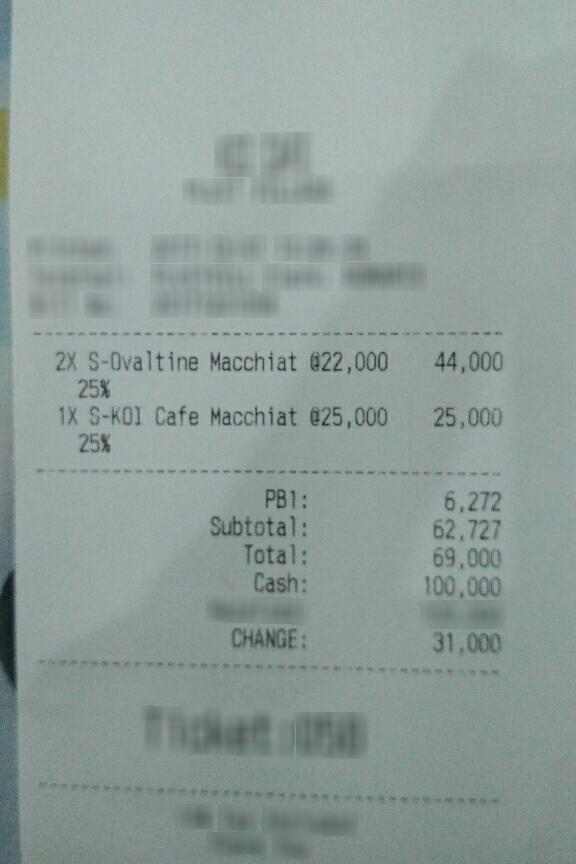

Sample 2:
Prediction  : $\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$

$\text{FÜNG}$
Ground truth: **O

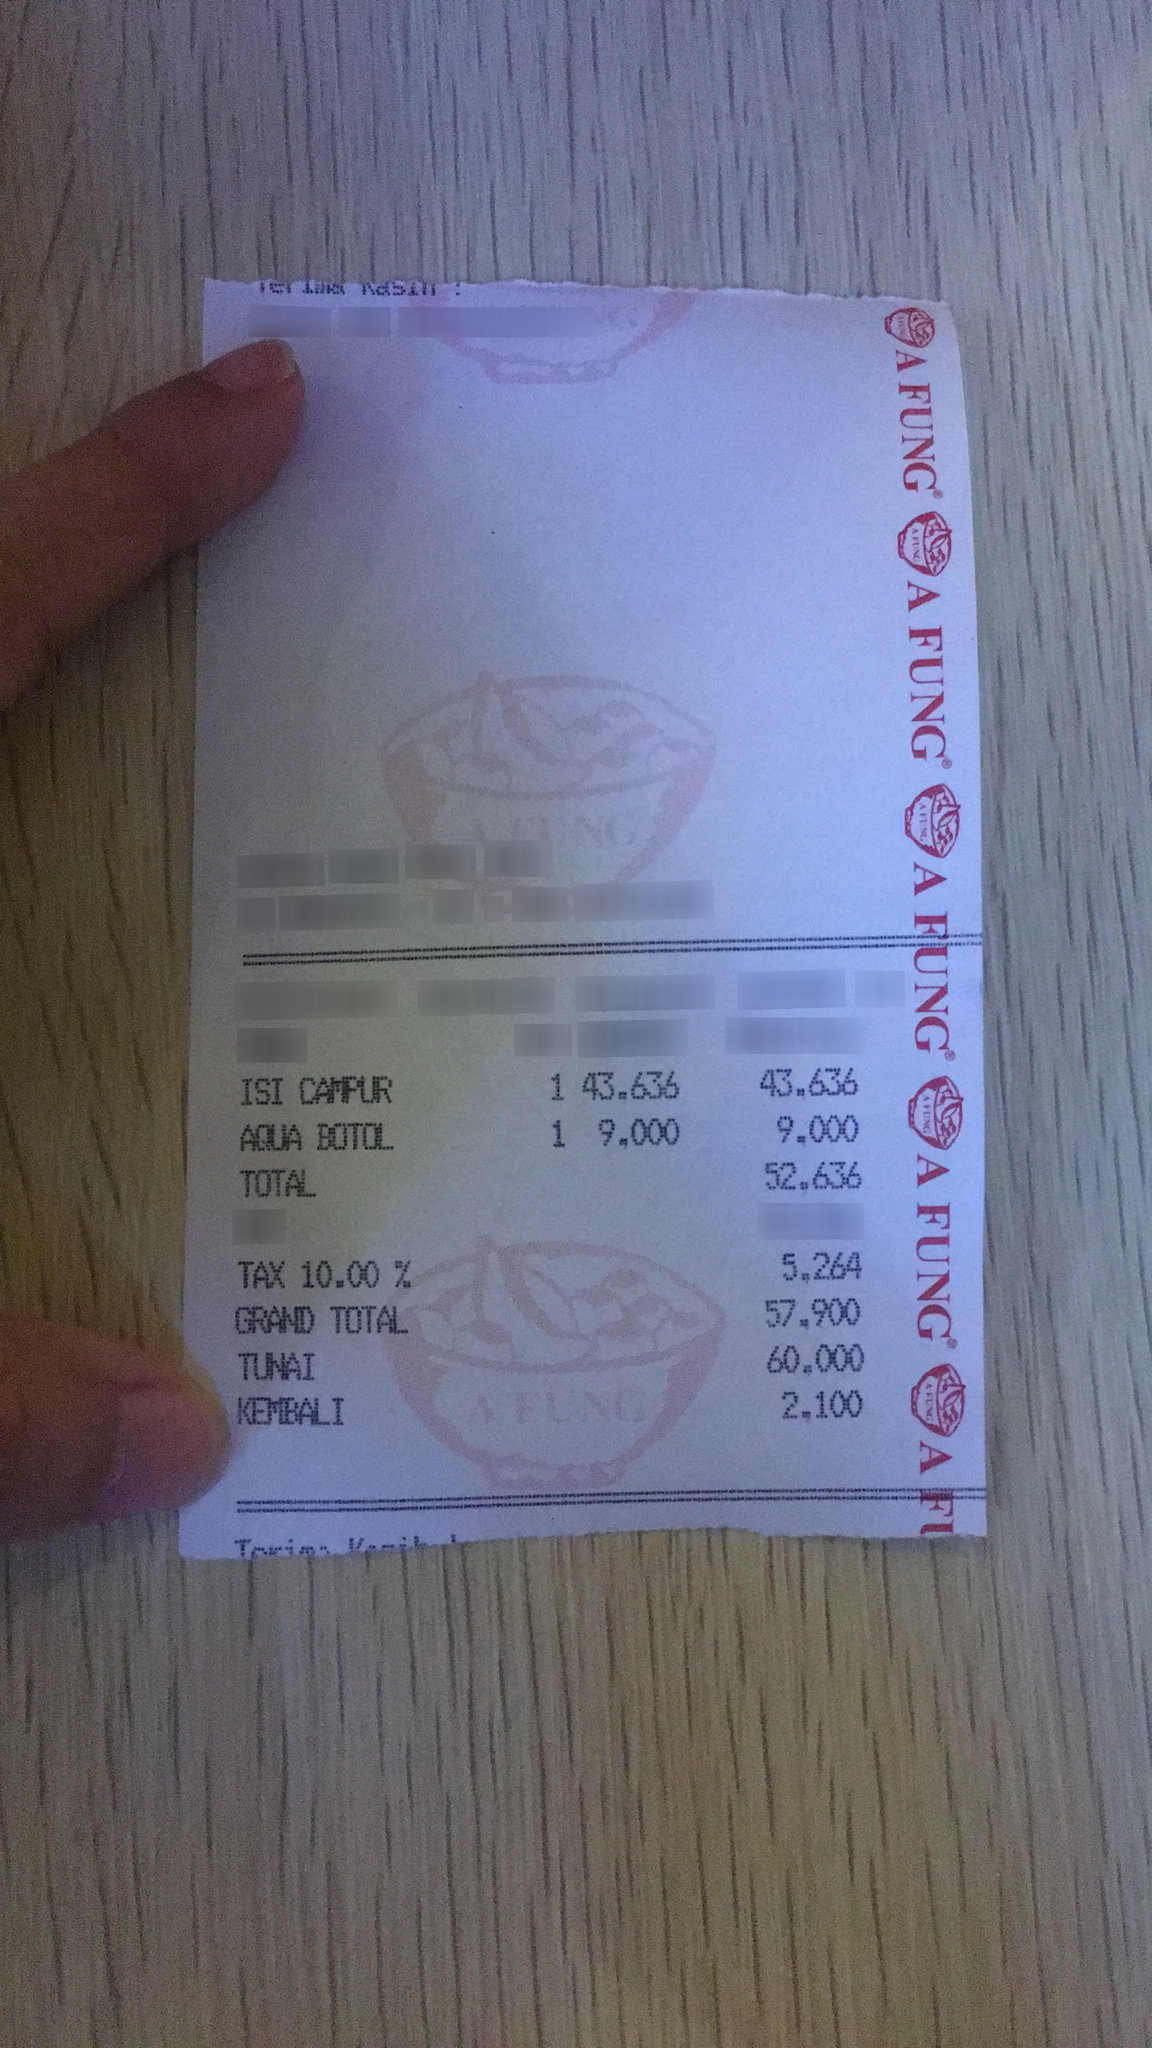

Sample 3:
Prediction  : <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1</td>
      <td>UDANG REBUS (M)</td>
      <td>162,000</td>
    </tr>
    <tr>
      <td></td>
      <td>=MEDIUM=</td>
      <td></td>
    </tr>
    <tr>
      <td>1</td>
      <td>AGSIO TH PC JMR</td>
      <td>147,000</td>
    </tr>
    <tr>
      <td></td>
      <td>=MEDIUM=</td>
      <td></td>
    </tr>
    <tr>
      <td>1</td>
      <td>AYAM GR KERING</td>
      <td>108,000</td>
    </tr>
    <tr>
      <td></td>
      <td>=MEDIUM=</td>
      <td></td>
    </tr>
    <tr>
      <td>1</td>
      <td>BIHUN GORENG JJ</td>
      <td>87,000</td>
    </tr>
    <tr>
      <td></td>
      <td>=MEDIUM=</td>
      <td></td>
    </tr>
    <tr>
      <td>1</td>
      <td>NASI GORENG NJUN</td>
      <td>87,000</td>
    </tr>
    <tr>
      <td></td>
      <td>=MEDIUM=</td>
      <td></td>
 

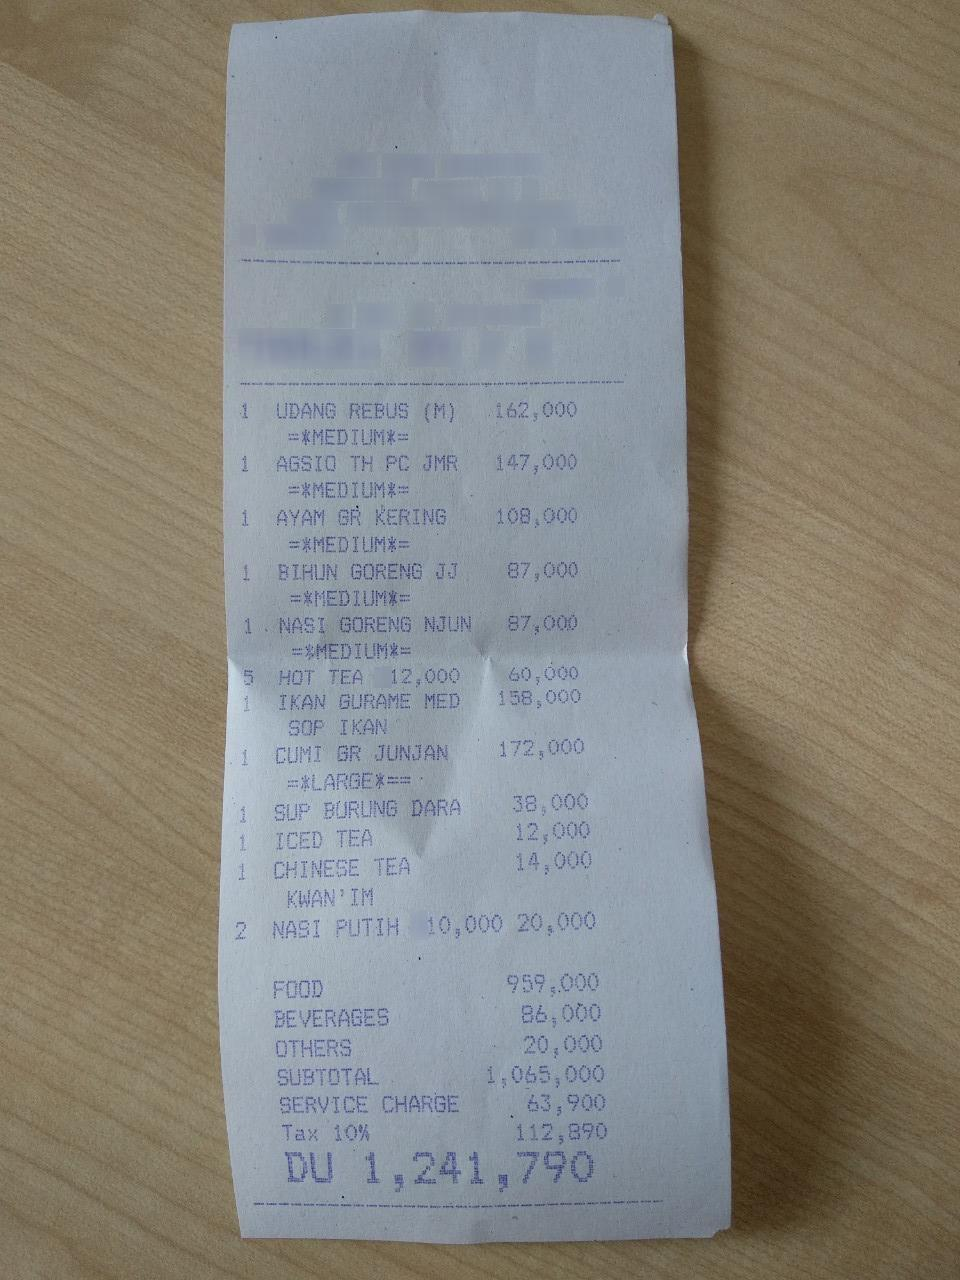

In [ ]:
def run_inference(image):
    """run inference on a single image"""
    messages = [
        {"role": "user", "content": [{"type": "image"}]}
    ]

    text = processor.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = processor(
        text=[text],
        images=[[image]],
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
        size={"longest_edge": LONGEST_EDGE},
    ).to(device)
    inputs['pixel_values'] = inputs['pixel_values'].to(torch.bfloat16)

    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        do_sample=True,
    )

    input_length = inputs['input_ids'].shape[1]
    generated_ids = outputs[0, input_length:]
    generated_text = processor.tokenizer.decode(generated_ids, skip_special_tokens=True)

    return generated_text.strip()

# test on a few samples
print("Testing base model on validation samples:\n")
for idx in range(3):
    sample = test_ds[idx]
    image = sample["images"][0]
    ground_truth = sample["texts"][0].get("assistant", "").strip()

    prediction = run_inference(image)

    print(f"Sample {idx + 1}:")
    print(f"Prediction  : {prediction}")
    print(f"Ground truth: {ground_truth}")
    print("-" * 50)

    # display image
    display(image)

Good news: LightOnOCR-2 already shows much better handwriting recognition ✍️ compared to v1! Training included some cropped images but limited handwriting samples, with the primary focus on full-page PDF documents 📄. Finetuning on your specific data can further boost performance on paragraph-level crops and diverse handwriting styles 🚀✨

## Lets evaluate the model before training

In [ ]:
from jiwer import cer, wer
import torch
from tqdm import tqdm

def evaluate_model(model, dataset, num_samples=50, batch_size=8, description="Model"):
    model.eval()

    predictions = []
    ground_truths = []

    print(f"\nEvaluating {description} on {num_samples} samples...")

    for start_idx in tqdm(range(0, min(num_samples, len(dataset)), batch_size)):
        end_idx = min(start_idx + batch_size, num_samples, len(dataset))
        batch_samples = [dataset[i] for i in range(start_idx, end_idx)]

        batch_images = [[s["images"][0]] for s in batch_samples]
        batch_ground_truths = [s["texts"][0]["assistant"].strip() for s in batch_samples]

        messages = [{"role": "user", "content": [{"type": "image"}]}]
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        texts = [text] * len(batch_images)

        inputs = processor(text=texts,
                           images=batch_images,
                           return_tensors="pt",
                           padding=True,
                           truncation=True,
                           max_length=MAX_LENGTH,
                           size={"longest_edge": LONGEST_EDGE},
                           ).to(device)
        inputs['pixel_values'] = inputs['pixel_values'].to(torch.bfloat16)

        outputs = model.generate(**inputs, max_new_tokens=512, do_sample=True)

        input_length = inputs['input_ids'].shape[1]
        generated_ids = outputs[:, input_length:]
        batch_predictions = processor.batch_decode(generated_ids, skip_special_tokens=True)
        batch_predictions = [p.strip() for p in batch_predictions]

        predictions.extend(batch_predictions)
        ground_truths.extend(batch_ground_truths)

    cer_score = cer(ground_truths, predictions) * 100
    wer_score = wer(ground_truths, predictions) * 100
    perfect_matches = sum(1 for pred, gt in zip(predictions, ground_truths) if pred == gt)

    print(f"CER: {cer_score:.2f}% | WER: {wer_score:.2f}% | Perfect: {perfect_matches}/{num_samples}")

    for i in range(min(3, len(predictions))):
        match = "✅" if predictions[i] == ground_truths[i] else "❌"
        print(f"{match} Sample {i+1}: '{predictions[i]}' vs '{ground_truths[i]}'")

    return {"cer": cer_score, "wer": wer_score, "perfect_matches": perfect_matches}

In [ ]:
from peft import PeftModel

print("\n" + "="*80)
print("BEFORE TRAINING")
print("="*80)

if isinstance(model, PeftModel):
    with model.disable_adapter():
        base_results = evaluate_model(model, test_ds, num_samples=100, batch_size=4, description="Base")
else:
    base_results = evaluate_model(model, test_ds, num_samples=100, batch_size=4, description="Base")

torch.cuda.empty_cache()


BEFORE TRAINING

Evaluating Base on 100 samples...


100%|██████████| 25/25 [3:25:26<00:00, 493.07s/it]

CER: 112.66% | WER: 114.20% | Perfect: 0/100
❌ Sample 1: '# CCA

## Model 14400

### Description: 2X S-Ovaltine Macchiat @22,000 44,000  
25%  
1X S-K01 Cafe Macchiat @25,000 25,000  
25%

---

PB1: 6,272  
Subtotal: 62,727  
Total: 69,000  
Cash: 100,000  
CHANGE: 31,000

---

**TROUVER 10%**

---

*Note: The image contains some faint, partially obscured text and logos at the top, which are not clearly legible and thus not included in the Markdown output.*' vs '**OCR Detected Words:** 2XS-0va1tine Macchiat @22.000, 44,000, 25%, 1X S-K01 Cafe Macchiat @25,000, 25,000, 25%, PB1:, 6,272, Subtotal:, 62,727, Total:, 69,000, Cash:, 100,000, CHANGE:, 31,000'
❌ Sample 2: '$\text{FOR THE PHASE I}$

$\text{CARFUNG}$

$\text{CARFUNG}$

$\text{CARFUNG}$

$\text{CARFUNG}$

<table>
  <tr>
    <td>ISTI CAPFUR</td>
    <td>1 43,636</td>
    <td>43,636</td>
  </tr>
  <tr>
    <td>AGUA BOTOL</td>
    <td>1 9,000</td>
    <td>9,000</td>
  </tr>
  <tr>
    <td>TOTAL</td>
    <td></td>
    <td>52,636</td>

## Configure Training Arguments

Set up the training configuration. Adjust based on your hardware and requirements.

In [ ]:
from transformers import TrainingArguments
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.set_float32_matmul_precision('high')

output_dir = f"LightOnOCR-2-ft-{finevision_subset}"
use_bf16 = torch.cuda.is_available()

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=1,
    # max_steps=100,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=6,
    gradient_accumulation_steps=4,
    learning_rate=6e-5,
    weight_decay=0.0,
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    bf16=use_bf16,
    fp16=False,
    remove_unused_columns=False,
    dataloader_pin_memory=False,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    warmup_steps=10,
    lr_scheduler_type="linear",
)

print(f"Output directory: {output_dir}")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")

Output directory: LightOnOCR-2-ft-invoices_receipts
Effective batch size: 16


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


## Initialize Trainer and Start Training

In [ ]:
from transformers import Trainer

# use a smaller set on Colab
val_ds_small = val_ds.select(range(100))
train_ds_small = train_ds.select(range(480))

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_small,
    eval_dataset=val_ds_small,
    data_collator=collate_fn,
)

print("Starting training...")
print(f"Number of training samples: {len(train_ds_small)}")
print(f"Number of validation samples: {len(val_ds_small)}")

Starting training...
Number of training samples: 480
Number of validation samples: 100


In [ ]:
trainer.train()

In [ ]:
import matplotlib.pyplot as plt

train_steps = []
train_losses = []
eval_steps = []
eval_losses = []

for entry in trainer.state.log_history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_losses.append(entry['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss', marker='o', linewidth=2)
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='s', linewidth=2)
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# evaluate the model after training
print("\n" + "="*80)
print("AFTER TRAINING")
finetuned_results = evaluate_model(model, test_ds, num_samples=100, batch_size=4, description="Finetuned")

In [ ]:
# comparison
print("\n" + "="*80)
print("COMPARISON")
print(f"{'Metric':<20} {'Base':<12} {'Finetuned':<12} {'Change':<12}")
print("-" * 56)
print(f"{'CER (%)':<20} {base_results['cer']:<12.2f} {finetuned_results['cer']:<12.2f} {base_results['cer']-finetuned_results['cer']:+.2f}")
print(f"{'WER (%)':<20} {base_results['wer']:<12.2f} {finetuned_results['wer']:<12.2f} {base_results['wer']-finetuned_results['wer']:+.2f}")
print(f"{'Perfect':<20} {base_results['perfect_matches']:<12} {finetuned_results['perfect_matches']:<12} {finetuned_results['perfect_matches']-base_results['perfect_matches']:+d}")
print("="*80)

With 2 epochs training, we can get even better results:

```bash
=========================================================
COMPARISON
Metric               Base         Finetuned    Change
--------------------------------------------------------
CER (%)              37.15        1.95         +35.20
WER (%)              41.89        5.07         +36.81
Perfect              54           166          +112
==========================================================
```



In [ ]:
%ls
!zip -r model_lighonocr.zip LightOnOCR-2-ft-iam

## Save and Push Model

Save the fine-tuned model and optionally push to Hugging Face Hub.

In [ ]:
# save model and processor
trainer.save_model(output_dir)
processor.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")

## Authentication

Authenticate to access the model and push your fine-tuned model to the Hub.

In [ ]:
from huggingface_hub import login

# Log in programmatically using the token
login(token="")

# Define the repository ID
hub_model_id = "staghado/LightOnOCR-2-1B-1025-ft-iam"

# Push to Hub
trainer.push_to_hub(hub_model_id)
processor.push_to_hub(hub_model_id)

In [ ]:
from huggingface_hub import notebook_login, logout
# logout()
notebook_login()
# optional: push to Hub
hub_model_id = "staghado/LightOnOCR-2-1B-1025-ft-iam"
trainer.push_to_hub(hub_model_id)
processor.push_to_hub(hub_model_id)


## Inference

Test the fine-tuned model on new images.

In [ ]:
# test on a validation sample
test_idx = 0
test_sample = val_ds[test_idx]
test_image = test_sample["images"][0]

print("Running inference...")
result = run_inference(test_image)

print("\n=== Generated Text ===")
print(result)

print("\n=== Ground Truth ===")
print(test_sample["texts"][0].get("assistant", ""))

display(test_image)

In [ ]:
# Test on multiple validation samples
print("="*50)
print("Testing Finetuned Model")
print("="*50)

num_samples = 5
for test_idx in range(num_samples):
    test_sample = val_ds[test_idx]
    test_image = test_sample["images"][0]
    ground_truth = test_sample["texts"][0]["assistant"]

    print(f"\n{'='*50}")
    print(f"Sample {test_idx + 1}:")

    # Run inference
    result = run_inference(test_image)

    print(f"Prediction  : {result}")
    print(f"Ground truth: {ground_truth}")

    # Calculate CER
    from jiwer import cer
    error_rate = cer([ground_truth], [result]) * 100
    print(f"CER: {error_rate:.2f}%")

    # Show if improved (you'll need base model predictions to compare)
    if result.strip() == ground_truth.strip():
        print("✅ Perfect match!")

    # Optional: display image
    # display(test_image)

print("\n" + "="*50)
print("Testing complete! 🚀")

## Convert Model for vLLM Compatibility

The current implementation of LightOnOCR on Transformers is based on the V5 version of Transformers and not vLLM for now.

If you want to use the model with vLLM afterwards, you need to update the config to use the following model types because the current vLLM implementation of LightOnOCR relies on them. This will be fixed soon so both Transformers and vLLM use the same names.


In [ ]:
import shutil
from huggingface_hub import hf_hub_download

vllm_output_dir = f"{output_dir}-vllm"

shutil.copytree(output_dir, vllm_output_dir)


VLLM_REQUIRED_FILES = [
    "config.json",
    "generation_config.json",
    "tokenizer_config.json",
    # "preprocessor_config.json",
    "processor_config.json",
    "tokenizer.json",
]

for filename in VLLM_REQUIRED_FILES:
    try:
        src_path = hf_hub_download(
            repo_id=model_id,
            filename=filename,
        )
        dst_path = os.path.join(vllm_output_dir, filename)
        shutil.copyfile(src_path, dst_path)
    except Exception as e:
        print(f"Warning: could not copy {filename}: {e}")

print("\n✅ vLLM-compatible model saved to:", output_dir)


In [ ]:
# from huggingface_hub import create_repo, upload_folder

# vllm_hub_model_id = "staghado/LightOnOCR-2-1B-1025-ft-iam-vllm"

# # Create a new repository on the Hugging Face Hub
# create_repo(repo_id=vllm_hub_model_id, repo_type="model", exist_ok=True)

# # Upload the contents of the vllm_output_dir to the newly created repository
# upload_folder(folder_path=vllm_output_dir, repo_id=vllm_hub_model_id, repo_type="model")

# print(f"vLLM-compatible model pushed to: https://huggingface.co/{vllm_hub_model_id}")

In [ ]:
!pip install dataset

In [ ]:
from datasets import load_dataset

ds = load_dataset("lightonai/LightOnOCR-mix-0126", split="pdfa_train")

def count_elements(batch):
    formulas = 0
    images = 0
    tables = 0

    # Count inside this batch
    for meta in batch["metadata"]:
        ec = meta.get("element_counts", {})
        formulas += int(ec.get("formulas", 0))
        images += int(ec.get("images", 0))
        tables += int(ec.get("tables", 0))

    # batch size = number of items in this batch
    bsz = len(batch["metadata"])

    # Repeat the result bsz times so the length matches
    return {
        "formulas_count": [formulas] * bsz,
        "images_count":   [images]   * bsz,
        "tables_count":   [tables]   * bsz,
    }

res = ds.map(count_elements, batched=True, batch_size=1000)

# Now safe to sum because each batch duplicated values
total_formulas = sum(res["formulas_count"]) / 1000  # divide again
total_images = sum(res["images_count"]) / 1000
total_tables = sum(res["tables_count"]) / 1000

print("sum formulas:", total_formulas)
print("sum images:", total_images)
print("sum tables:", total_tables)


In [ ]:
from datasets import load_dataset

ds = load_dataset("lightonai/LightOnOCR-mix-0126", split="pdfa_train")

total_formulas = 0
total_images = 0
total_tables = 0

for item in ds:
    ec = item["metadata"]["element_counts"]
    total_formulas += int(ec.get("formulas", 0))
    total_images += int(ec.get("images", 0))
    total_tables += int(ec.get("tables", 0))

print("sum formulas:", total_formulas)
print("sum images:", total_images)
print("sum tables:", total_tables)
